In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import pyodbc as p1
import numpy as np

conn = p1.connect(r'Driver={SQL Server}; Server=DESKTOP-R6USKL7\MSSQL_DNST; Database=MortgageData; Trusted_Connection=yes;')
cursor1 = conn.cursor()
sqlQuery1 =  """\
    WITH CTE_DATA1 AS 
    (
        SELECT 
            B1.*,
            P1.Agency,
            AVG(L1.FICO) OVER (PARTITION BY B1.SELECTED_POOL_ID) AVG_CREDIT_SCORE,
            ROW_NUMBER () OVER (PARTITION BY B1.SELECTED_POOL_ID ORDER BY B1.LOANID) ROWNUMBER
        FROM BaseLine AS B1 
            LEFT JOIN LoanData AS L1 
                ON B1.LoanID = L1.LoanID
            LEFT JOIN PoolOptionData AS P1
                ON B1.Selected_Pool_ID = P1.Pool_Option_j
    )
    SELECT 
        SUM ( LESS_THAN_600 ) LESS_THAN_600 , 
        SUM ( BETWEEN_600_650) BETWEEN_600_650,
        SUM ( BETWEEN_650_700) BETWEEN_650_700,
        SUM ( BETWEEN_700_750) BETWEEN_700_750,
        SUM ( BETWEEN_750_800) BETWEEN_750_800
    FROM
    (
        SELECT 
            CASE WHEN AVG_CREDIT_SCORE < 600 THEN COUNT(*) ELSE 0 END LESS_THAN_600,
            CASE WHEN AVG_CREDIT_SCORE >= 600 AND AVG_CREDIT_SCORE < 650 THEN COUNT(*) ELSE 0 END BETWEEN_600_650,
            CASE WHEN AVG_CREDIT_SCORE >= 650 AND AVG_CREDIT_SCORE < 700 THEN COUNT(*) ELSE 0 END BETWEEN_650_700,
            CASE WHEN AVG_CREDIT_SCORE >= 700 AND AVG_CREDIT_SCORE < 750 THEN COUNT(*) ELSE 0 END BETWEEN_700_750,
            CASE WHEN AVG_CREDIT_SCORE >= 750 AND AVG_CREDIT_SCORE < 800 THEN COUNT(*) ELSE 0 END BETWEEN_750_800
        FROM CTE_DATA1 AS C1
        WHERE ROWNUMBER = 1
        GROUP BY AVG_CREDIT_SCORE
    )AS A1

"""

cursor1.execute(sqlQuery1)
df1 = cursor1.fetchall()
cursor1.close()
conn.close()




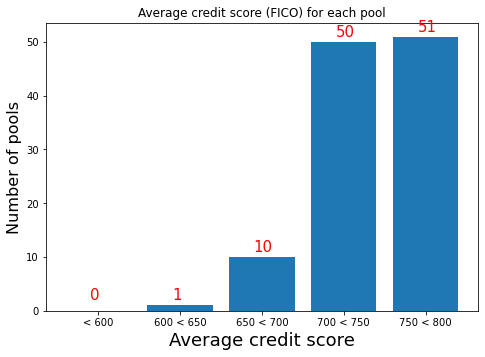

In [8]:
#######################  DASHBOARD 1: Number of average credit score for per pool #######################
fig1 = plt.figure()
ax1 = fig1.add_axes([0,0,1,1])
avg_FICO = ['< 600', '600 < 650', '650 < 700', '700 < 750', '750 < 800']
values = list(df1[0])
for i, v in enumerate(values):
    if values[i] == 0:
        ax1.text(i-.10, 
              2, 
              values[i], 
              fontsize=15, 
              color='red')
    else:
        ax1.text(i-.10, 
              v/values[i] + values[i], 
              values[i], 
              fontsize=15, 
              color='red')
ax1.bar(avg_FICO,values)
plt.xlabel('Average credit score', fontsize=18)
plt.ylabel('Number of pools', fontsize=16)
plt.title('Average credit score (FICO) for each pool')
plt.show()


#######################  Showing all list of pools which has bad score loans (less than 700) #######################  

import plotly.graph_objects as go
from plotly.subplots import make_subplots

conn = p1.connect(r'Driver={SQL Server}; Server=DESKTOP-R6USKL7\MSSQL_DNST; Database=MortgageData; Trusted_Connection=yes;')
cursor1 = conn.cursor()
sqlQuery2 =  """\
        WITH CTE_DATA2 AS (
        SELECT 
            B1.*,
            P1.Agency,
            AVG(L1.FICO) OVER (PARTITION BY B1.SELECTED_POOL_ID) AVG_CREDIT_SCORE,
            AVG(B1.PRICE) OVER (PARTITION BY B1.SELECTED_POOL_ID) AVG_PRICE,
            ROW_NUMBER () OVER (PARTITION BY B1.SELECTED_POOL_ID ORDER BY B1.LOANID) ROWNUMBER,
            COUNT (B1.LOANID) OVER (PARTITION BY B1.SELECTED_POOL_ID ) NUMBER_OF_LOAN_COUNT
        FROM BaseLine AS B1 
            LEFT JOIN LoanData AS L1 
                ON B1.LoanID = L1.LoanID
            LEFT JOIN PoolOptionData AS P1
                ON B1.Selected_Pool_ID = P1.Pool_Option_j
    )
    SELECT 
        SELECTED_POOL_ID, 
        AGENCY, 
        ROUND(AVG_CREDIT_SCORE,2)AVG_CREDIT_SCORE, 
        ROUND(AVG_PRICE,2) AVG_PRICE, 
        NUMBER_OF_LOAN_COUNT
    FROM CTE_DATA2
    WHERE ROWNUMBER = 1
    AND AVG_CREDIT_SCORE <= 700
    ORDER BY 3 ASC
"""

cursor1.execute(sqlQuery2)
df2 = cursor1.fetchall()
cursor1.close()
conn.close()

fig = make_subplots(
    rows=1, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    specs=[[{"type": "table"}]]
)

columns2 = ['SELECTED_POOL_ID', 'AGENCY', 'AVG_CREDIT_SCORE', 'AVG_PRICE', 'NUMBER_OF_LOAN_COUNT']

fig.add_trace(
    go.Table(
        header=dict(
            values = columns2,
            font = dict(size=12),
            align="left"
        ),
        cells=dict(
            values=[[df2[i][j] for i in range (0,len(df2))] for j in range(0, len(columns2)) ] ,
            align = "left")
    ),
    row=1, col=1
)

fig.update_layout(
    height=450,
    showlegend=False,
    title_text="List of pools which has BAD credit score loans",
)

fig.show()




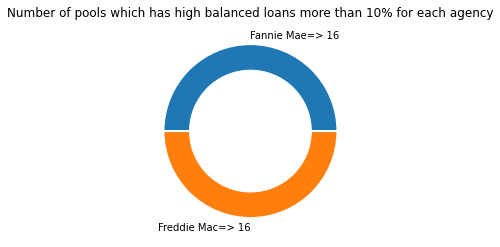

In [71]:
#######################  DASHBOARD 2: Number of average credit score for per pool #######################
import matplotlib.pyplot as plt
 

conn = p1.connect(r'Driver={SQL Server}; Server=DESKTOP-R6USKL7\MSSQL_DNST; Database=MortgageData; Trusted_Connection=yes;')
cursor2 = conn.cursor()
sqlQuery2 =  """\
        SELECT Agency, COUNT(*) COUNT_OF_POOLS
        FROM
        (
            SELECT Pool_Option_j, Pool_Type, Agency, Pool_Balance_Type, Servicer,
                SUM(HIGH_BAL_Y) HIGH_BAL_Y, 
                SUM(HIGH_BAL_N) HIGH_BAL_N,
                ( SUM(HIGH_BAL_Y)  * 100 ) / (SUM(HIGH_BAL_Y) + SUM(HIGH_BAL_N)) PERCENTAGE
            FROM
            (
                SELECT P1.Pool_Option_j, P1.Pool_Type, P1.Agency, P1.Pool_Balance_Type, P1.Servicer,
                    CASE WHEN L1.HighBalFlag = 'Y' THEN COUNT(*) ELSE 0 END HIGH_BAL_Y,
                    CASE WHEN L1.HighBalFlag = 'N' THEN COUNT(*) ELSE 0 END HIGH_BAL_N
                FROM EligiblePriceComb AS E1 
                    LEFT JOIN LoanData AS L1
                        ON E1.LoanID = L1.LoanID
                    LEFT JOIN PoolOptionData AS P1
                        ON E1.Pool_Opton_j = P1.Pool_Option_j
                WHERE P1.Pool_Balance_Type = 'Standard Balance'
                GROUP BY P1.Pool_Option_j, P1.Pool_Type, P1.Agency, P1.Pool_Balance_Type, P1.Servicer, L1.HighBalFlag
            ) AS P2
            GROUP BY Pool_Option_j, Pool_Type, Agency, Pool_Balance_Type, Servicer
            HAVING (( SUM(HIGH_BAL_Y)  * 100 ) / (SUM(HIGH_BAL_Y) + SUM(HIGH_BAL_N)) >=10)
        ) AS A1
        GROUP BY AGENCY
"""

cursor2.execute(sqlQuery2)
df3 = cursor2.fetchall()
cursor2.close()
conn.close()

names=[str(df3[i][0]) + '=> ' + str(df3[i][1]) for i in range(0, len(df3))]
size=[df3[i][1] for i in range(0, len(df3))]
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, wedgeprops = { 'linewidth' : 2, 'edgecolor' : 'white' })
plt.title('Number of pools which has high balanced loans more than 10% for each agency')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()




#######################  Showing all list of pools which has high balanced loans more than 10% for each agency #######################  

import plotly.graph_objects as go
from plotly.subplots import make_subplots

conn = p1.connect(r'Driver={SQL Server}; Server=DESKTOP-R6USKL7\MSSQL_DNST; Database=MortgageData; Trusted_Connection=yes;')
cursor1 = conn.cursor()
sqlQuery2 =  """\
       SELECT Pool_Option_j, Pool_Type, Agency, Pool_Balance_Type, Servicer,
            SUM(HIGH_BAL_Y) HIGH_BAL_Y, 
            ( SUM(HIGH_BAL_Y)  * 100 ) / (SUM(HIGH_BAL_Y) + SUM(HIGH_BAL_N)) PERCENTAGE
        FROM
        (
            SELECT P1.Pool_Option_j, P1.Pool_Type, P1.Agency, P1.Pool_Balance_Type, P1.Servicer,
                CASE WHEN L1.HighBalFlag = 'Y' THEN COUNT(*) ELSE 0 END HIGH_BAL_Y,
                CASE WHEN L1.HighBalFlag = 'N' THEN COUNT(*) ELSE 0 END HIGH_BAL_N
            FROM EligiblePriceComb AS E1 
                LEFT JOIN LoanData AS L1
                    ON E1.LoanID = L1.LoanID
                LEFT JOIN PoolOptionData AS P1
                    ON E1.Pool_Opton_j = P1.Pool_Option_j
            WHERE P1.Pool_Balance_Type = 'Standard Balance'
            GROUP BY P1.Pool_Option_j, P1.Pool_Type, P1.Agency, P1.Pool_Balance_Type, P1.Servicer, L1.HighBalFlag
        ) AS P2
        GROUP BY Pool_Option_j, Pool_Type, Agency, Pool_Balance_Type, Servicer
        HAVING (( SUM(HIGH_BAL_Y)  * 100 ) / (SUM(HIGH_BAL_Y) + SUM(HIGH_BAL_N)) >=10)
"""

cursor1.execute(sqlQuery2)
df2 = cursor1.fetchall()
cursor1.close()
conn.close()

fig = make_subplots(
    rows=1, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    specs=[[{"type": "table"}]]
)

columns2 = ['Pool Id', 'Pool type', 'Agency', 'Pool Balance Type', 'Servicer', 'Number of HB Loans','Percentage of HB Loans']

fig.add_trace(
    go.Table(
        header=dict(
            values = columns2,
            font = dict(size=12),
            align="left"
        ),
        cells=dict(
            values=[[df2[i][j] for i in range (0,len(df2))] for j in range(0, len(columns2)) ] ,
            align = "left")
    ),
    row=1, col=1
)

fig.update_layout(
    height=450,
    showlegend=False,
    title_text="List of pools which has high balanced loans more than 10%",
)

fig.show()


